#### https://online.stat.psu.edu/stat510/lesson/3

In [62]:
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ARIMA models include 3 things: AR terms, MA terms, differencing operations. In brief, ARIMA(p,d,q). For example, ARIMA(2,1,2) means p=2, d=1, q=2

#### Four items should be considered to determine the first guess of ARIMA: a time series plot, ACF, PACF, scatter plot of $x_t$ vs. $x_{t-h}$

As mentioned, we use PACF to find AR lags, use ACF to find MA lags. When it comes to ARMA models, the order will not be particularly obvious. 

In [3]:
Image(url="ARMA11_example.png", width=600, height=600)

#### After you've made a guess or two at a possible model, estimate the coefficients. Most softwares use MLE to do so. After obtaining the coefficients,

<ol>
    <li>Look at the significance of the coefficients</li>
    <li>Look at the ACF of the residuals</li>
    <li>Look at LB tests</li>
    <li>If non-constant variance is a concern, plot resids vs. fits as well as a time seires plot of the residuals</li>
</ol>

#### If more than one model looks okay, you caompre modles using MSE, AIC, BIC, etc.

In [8]:
eriedata = """
14.383   14.649   13.416   14.288   12.201   14.307   13.586   14.592
16.660   15.332   12.884   12.296   12.201   10.873   11.290   12.049
13.435   14.137   13.852   14.213   12.562   14.801   16.812   15.427
17.268   15.427   16.869   15.712   14.080   15.408   16.471   17.268
16.679   17.116   16.357   15.863   14.991   13.776   13.890   15.787
"""

In [31]:
tmp = eriedata.split("\n")[1:-1]
tmp = list(map(lambda arr: arr.split("   "), tmp))
tmp = np.array(tmp).flatten()
eriedata_series = pd.Series(tmp, dtype=float)

1. Time Series Plot

<AxesSubplot:>

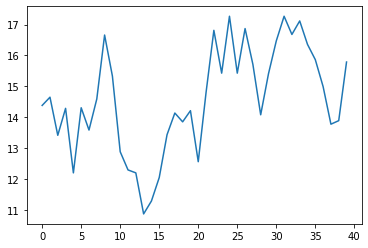

In [33]:
eriedata_series.plot()

2. ACF

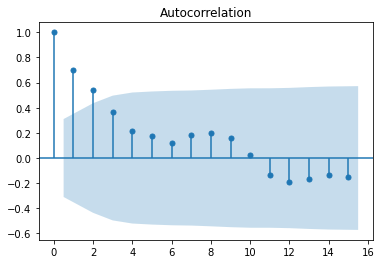

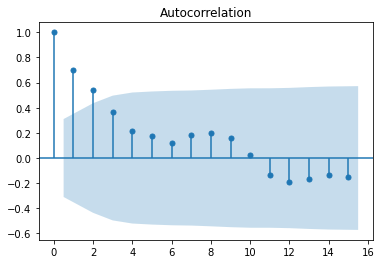

In [38]:
plot_acf(eriedata_series, lags=15)

3. PACF

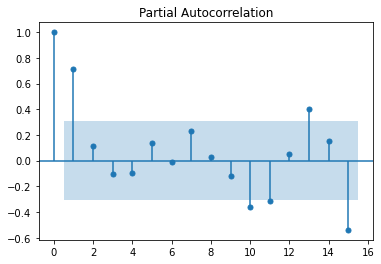

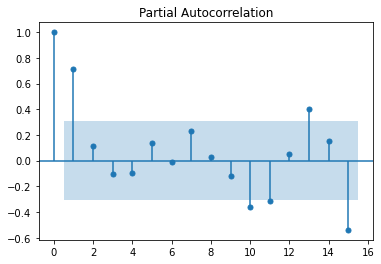

In [39]:
plot_pacf(eriedata_series, lags=15)

4. $x_t$ vs. $x_{t-h}$

In [43]:
df = pd.DataFrame({
    'lag0':eriedata_series,
    'lag1':eriedata_series.shift(1),
    'lag2':eriedata_series.shift(2),
    'lag3':eriedata_series.shift(3),
    'lag4':eriedata_series.shift(4),
})

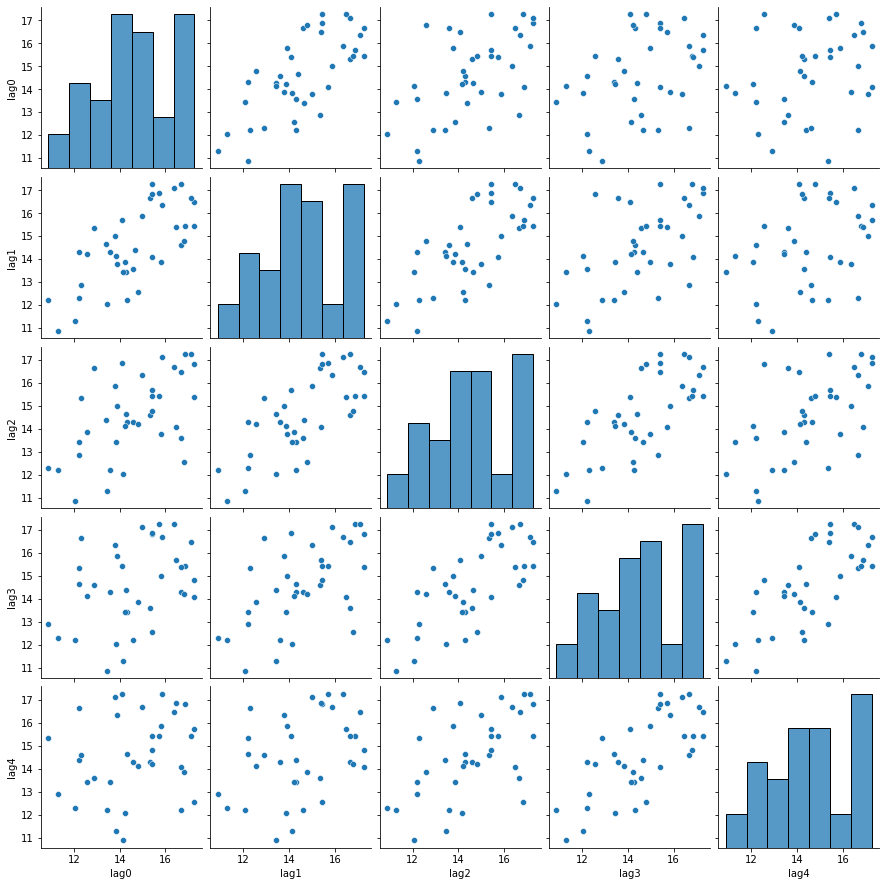

In [44]:
sns.pairplot(df)

#### We checked 4 items. We can start with AR(1) model

In [45]:
from statsmodels.tsa.ar_model import AutoReg

In [48]:
model = AutoReg(eriedata_series, lags=1).fit()
model.summary()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                     AutoReg(1)   Log Likelihood                 -63.012
Method:               Conditional MLE   S.D. of innovations              1.217
Date:                Fri, 01 Jul 2022   AIC                              0.547
Time:                        21:39:15   BIC                              0.675
Sample:                             1   HQIC                             0.593
                                   40                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2878      1.678      2.555      0.011       0.998       7.577
y.L1           0.7078      0.115      6.177      0.000       0.483       0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4129           +0.0000j            1.4129            0.0000
-----------------------------------------------------------------------------
"""

After fitting,

1. look at significance: intercept & param both significant

2. ACF of residuals

<AxesSubplot:>

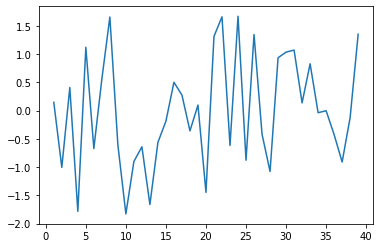

In [58]:
standardized_resid = ((model.resid - model.resid.mean())/model.resid.std())
standardized_resid.plot()

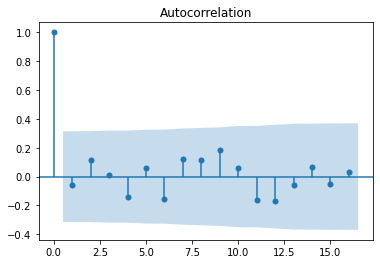

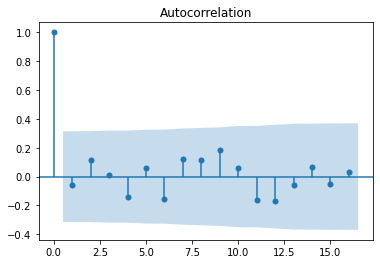

In [59]:
plot_acf(model.resid)

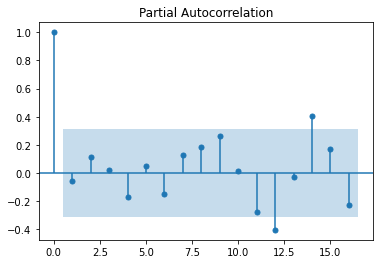

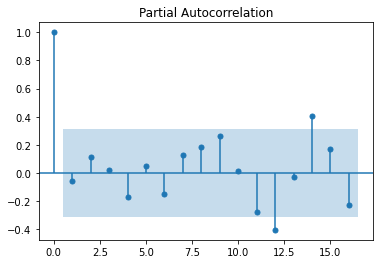

In [60]:
plot_pacf(model.resid)

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


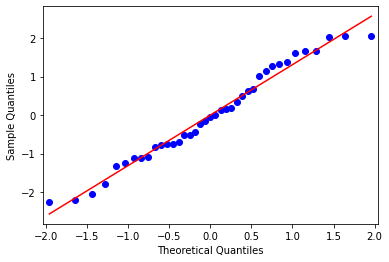

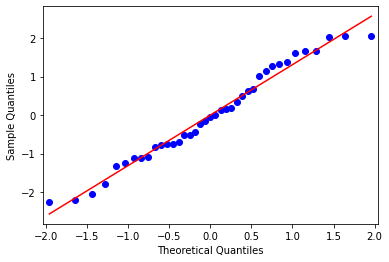

In [64]:
sm.qqplot(model.resid, line ='r')

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


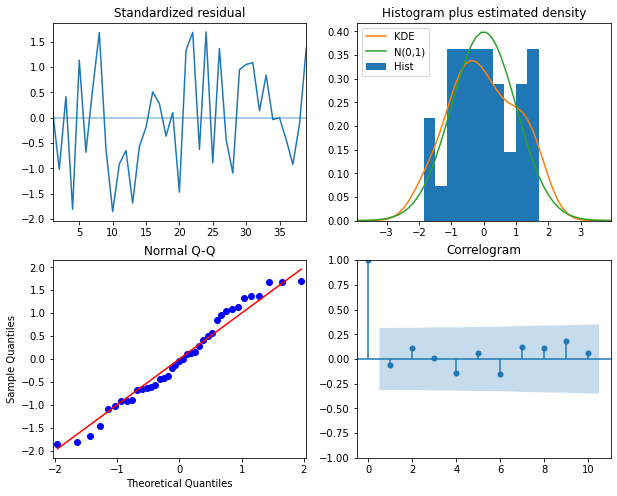

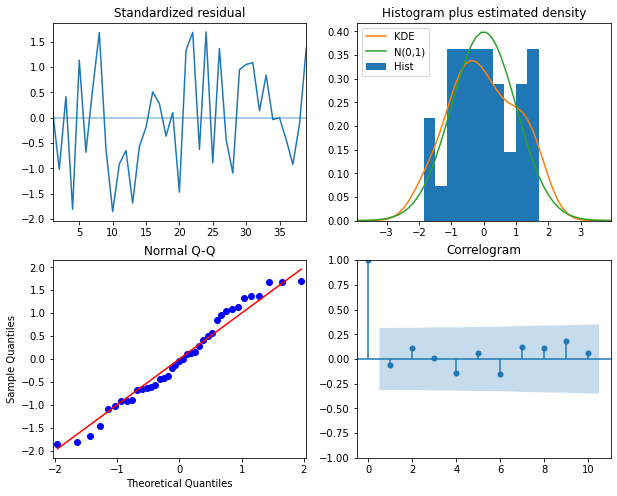

In [66]:
model.plot_diagnostics(figsize=(10,8))

3. Ljung-Box statistic

All p-values are above the threshold 0.05, that's a good result

In [67]:
model.test_serial_correlation()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:2027: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly set lags to silence this warning.
  warnings.warn(


,Ljung-Box,LB P-value,DF
Lag,,,
1,0.139858,NaN,0
2,0.700322,0.402676,1
3,0.703946,0.703299,2
4,1.589104,0.661863,3
5,1.761659,0.779489,4
6,2.953778,0.707112,5
7,3.661177,0.722417,6
8,4.350235,0.738668,7
9,6.100300,0.635998,8


What would happen if we pick a wrong model?

In [70]:
from statsmodels.tsa.arima_model import ARIMA

In [72]:
model = ARIMA(eriedata_series, order=(0,0,1)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73647D+00    |proj g|=  2.96390D-03

At iterate    5    f=  1.73645D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     23      1     0     0   0.000D+00   1.736D+00
  F =   1.7364522568612100     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


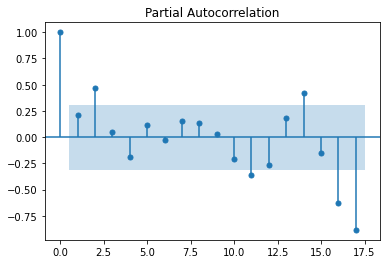

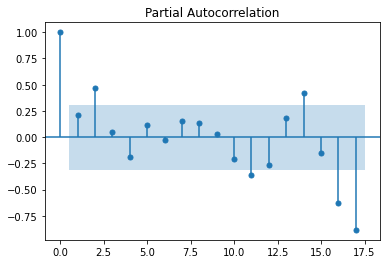

In [73]:
plot_pacf(model.resid)